# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][0]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58744.51180555556 

EndTime
58744.537152777775 

IntegrationTime
2190.0 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J0542+4951


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7622531831}, 'm1': {'unit': 'rad', 'value': 0.7202694229000001}, 'refer': 'J2000', 'type': 'direction'}
name :  J1033+4116


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8307109711}, 'm1': {'unit': 'rad', 'value': 0.8137042526}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1048+4637


field_3
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0145677806}, 'm1': {'unit': 'rad', 'value': 0.6676783576000002}, 'refer': 'J2000', 'type': 'direction'}
name :  J1130+3815


field_4
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 3.0425255836}, 'm1': {'unit': 'rad', 'value': 0.6253943770000001}, 'refer': 'J20

### Array Layout

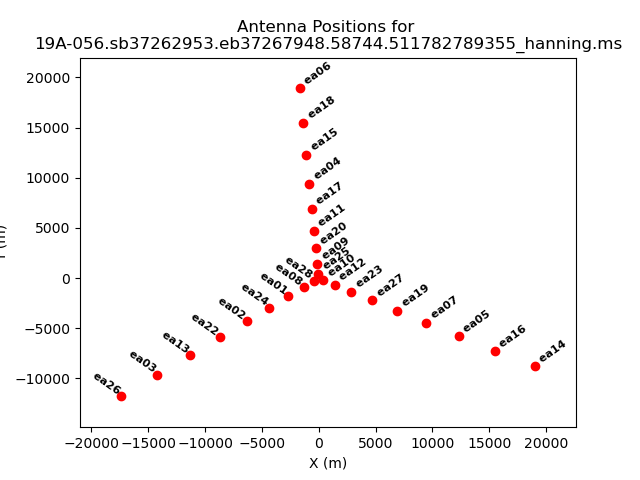

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

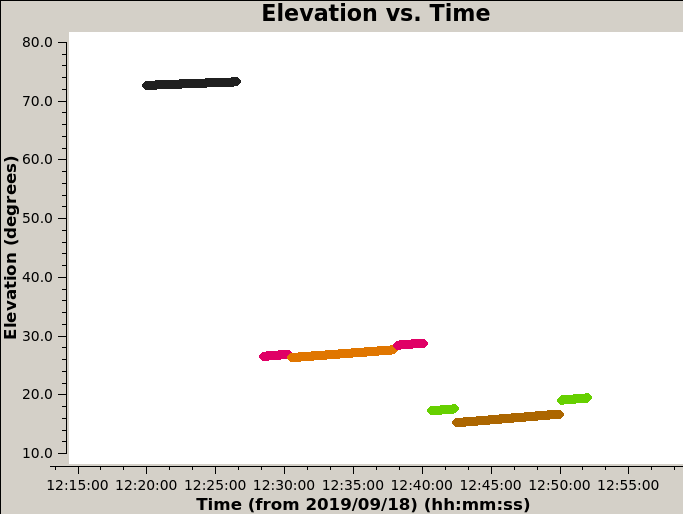

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field J0542+4951
Before: 70.5618, After: 70.2850

field J1033+4116
Before: 79.2853, After: 79.2744

field J1130+3815
Before: 71.3757, After: 71.3592

field QSO J1048+4637
Before: 65.3612, After: 65.3284

field QSO J1137+3549
Before: 64.1705, After: 64.0984

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 67.0984, After: 66.7891

scan 3
Before: 86.3847, After: 86.3754

scan 4
Before: 65.3612, After: 65.3284

scan 5
Before: 66.8354, After: 66.8219

scan 6
Before: 75.0709, After: 75.0540

scan 7
Before: 64.1705, After: 64.0984

scan 8
Before: 67.2187, After: 67.2026

antenna ea01
Before: 66.1539, After: 66.0193

antenna ea02
Before: 65.9785, After: 65.7458

antenna ea03
Before: 65.6665, After: 65.5520

antenna ea04
Before: 65.4284, After: 65.3454

antenna ea05
Before: 65.5941, After: 65.4984

antenna ea06
Before: 65.5223, After: 65.4303

antenna ea07
Before: 65.7380, After: 65.6310

antenna ea08
Before: 66.1223, Afte

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

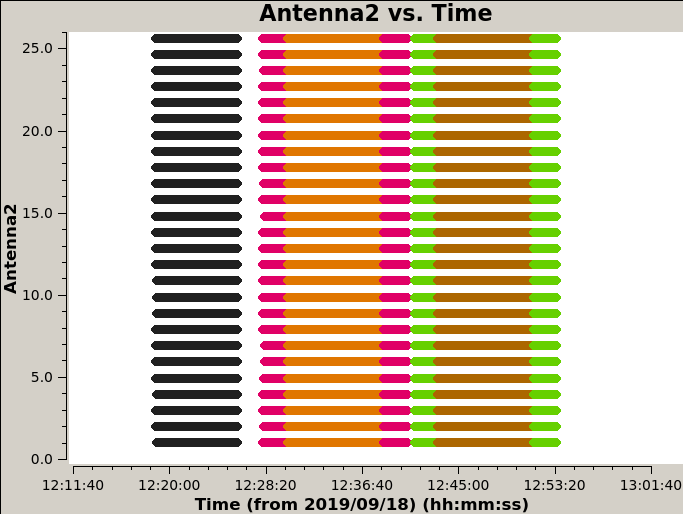

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

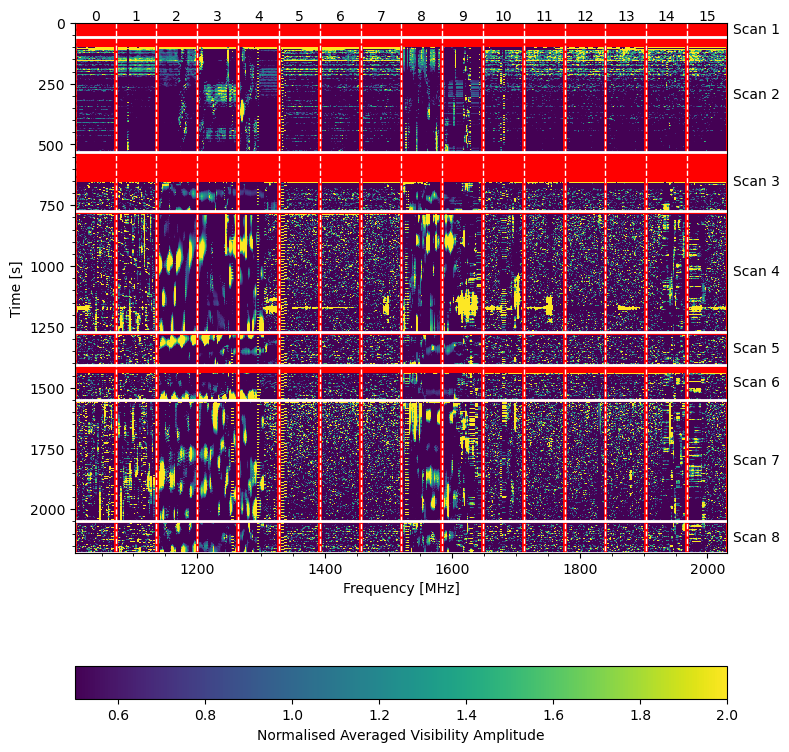

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [11]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

In [12]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field J0542+4951
Before: 70.2850, After: 70.2850

field J1033+4116
Before: 79.2744, After: 79.2744

field J1130+3815
Before: 71.3592, After: 71.3592

field QSO J1048+4637
Before: 65.3284, After: 65.3284

field QSO J1137+3549
Before: 64.0984, After: 64.0984

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 66.7891, After: 66.7891

scan 3
Before: 86.3754, After: 86.3754

scan 4
Before: 65.3284, After: 65.3284

scan 5
Before: 66.8219, After: 66.8219

scan 6
Before: 75.0540, After: 75.0540

scan 7
Before: 64.0984, After: 64.0984

scan 8
Before: 67.2026, After: 67.2026

antenna ea01
Before: 66.0193, After: 66.0193

antenna ea02
Before: 65.7458, After: 65.7458

antenna ea03
Before: 65.5520, After: 65.5520

antenna ea04
Before: 65.3454, After: 65.3454

antenna ea05
Before: 65.4984, After: 65.4984

antenna ea06
Before: 65.4303, After: 65.4303

antenna ea07
Before: 65.6310, After: 65.6310

antenna ea08
Before: 66.0183, After: 66.0

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [13]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


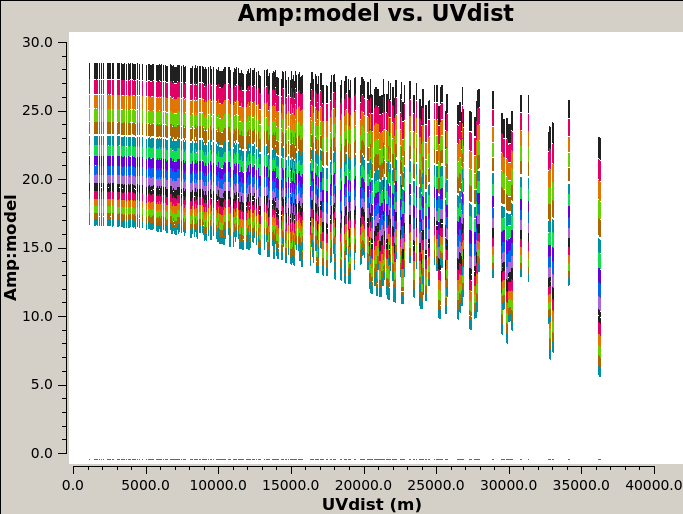

In [14]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

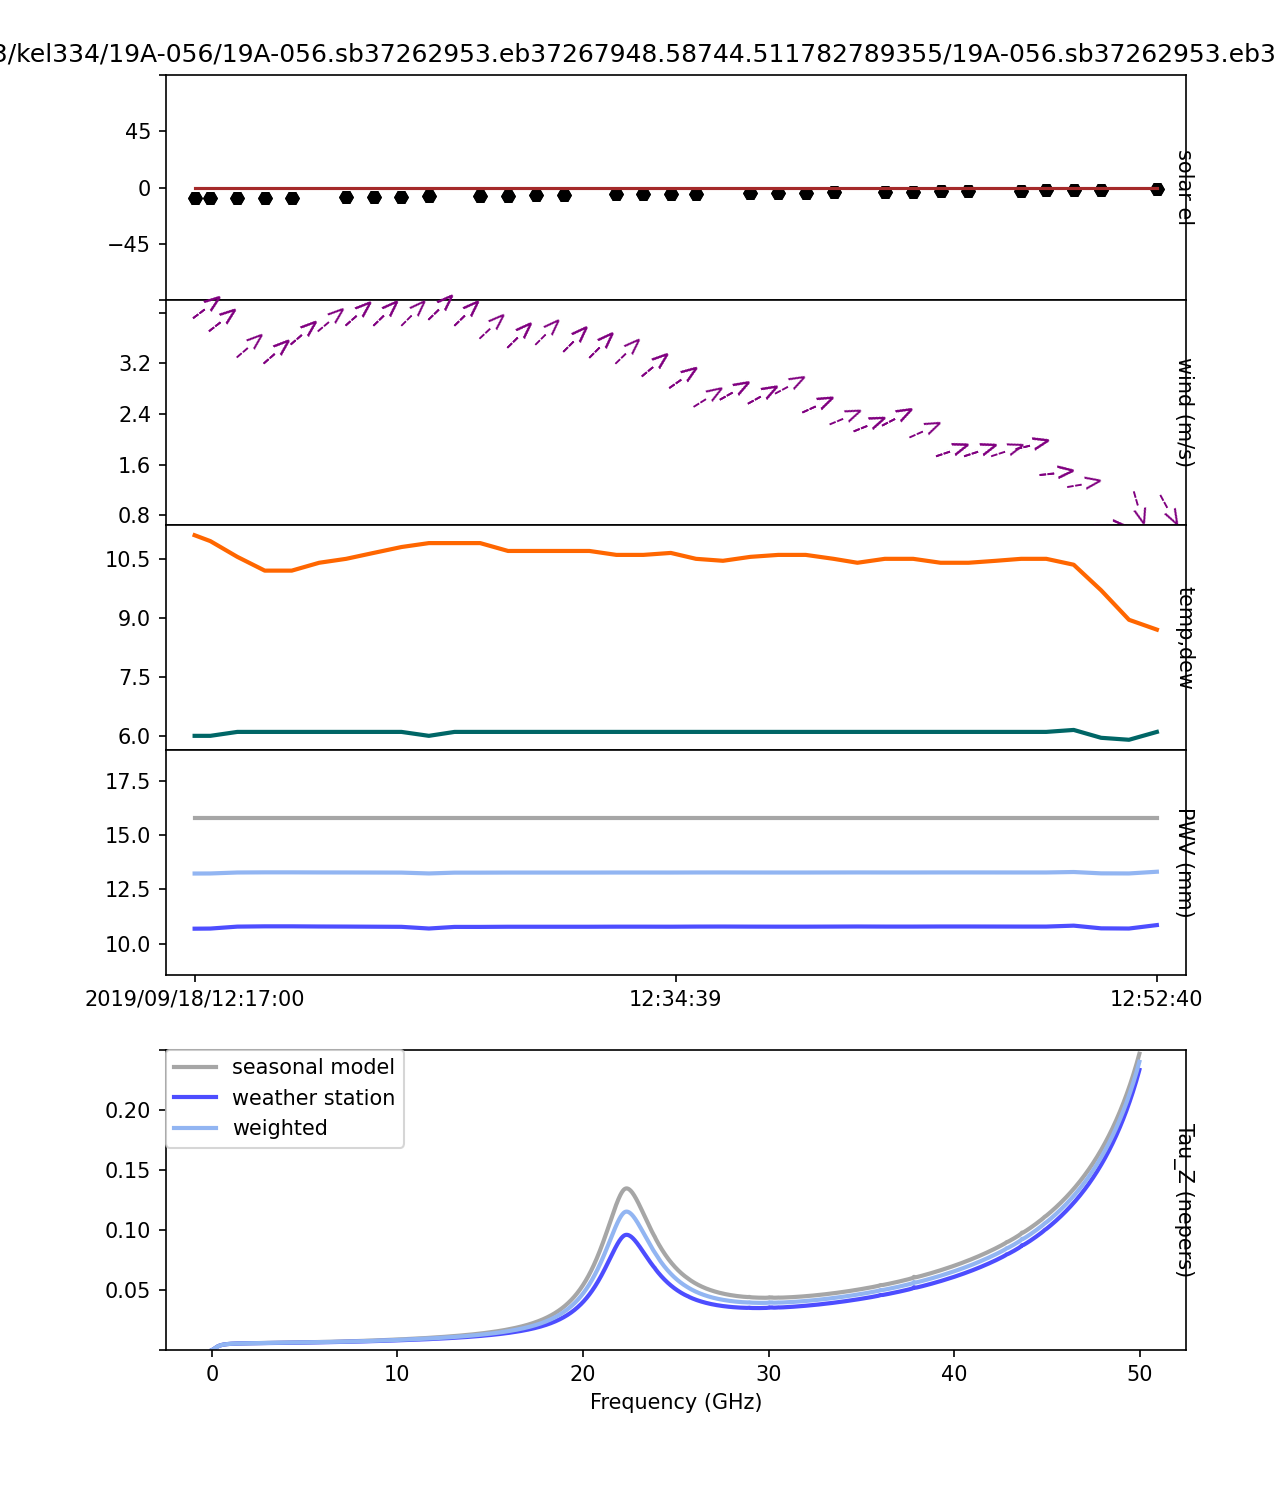

In [15]:
Image(filename=root + "/plots/calplots/weather.png")

In [16]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005156145504670995
SPW 1: 0.00521604230001692
SPW 2: 0.005268136303951705
SPW 3: 0.005313652182663858
SPW 4: 0.005354030156365918
SPW 5: 0.0053898666424734
SPW 6: 0.005422094745459627
SPW 7: 0.005451188753034495
SPW 8: 0.005477678822838807
SPW 9: 0.005501972286118477
SPW 10: 0.00552435923269206
SPW 11: 0.005545187791168971
SPW 12: 0.005564605491689138
SPW 13: 0.005582893355940872
SPW 14: 0.0056001610765702104
SPW 15: 0.0056165880715353745


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

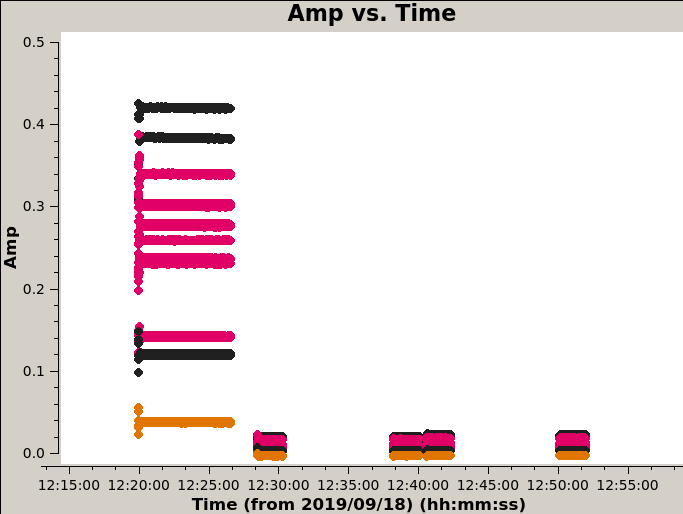

In [17]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [18]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [19]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [20]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

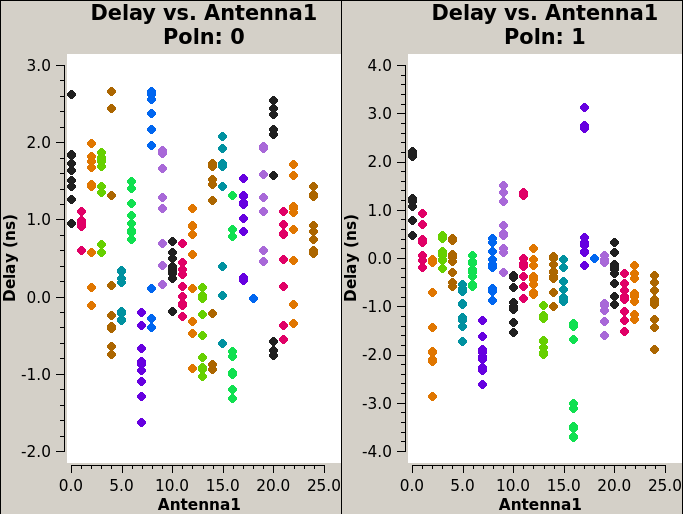

In [21]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [22]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [23]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [24]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

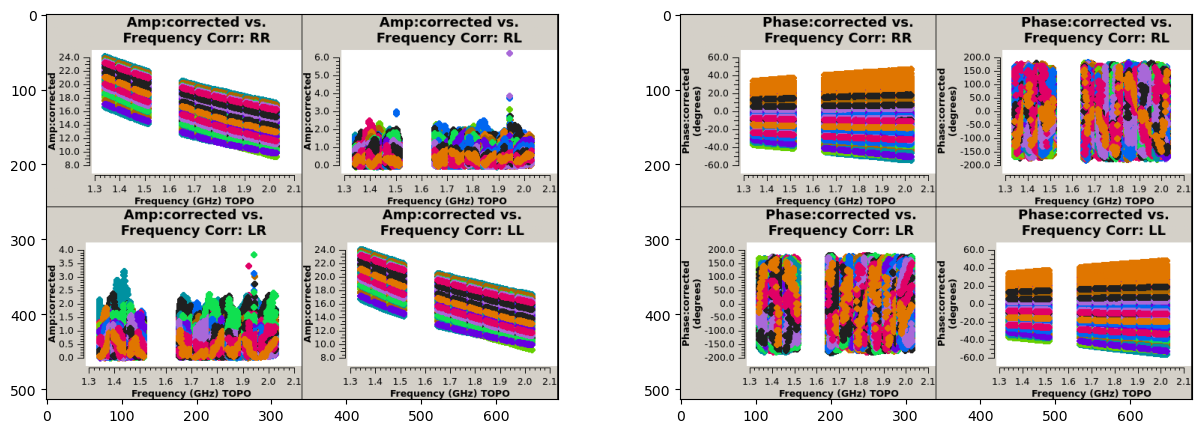

In [25]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [26]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [27]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field J0542+4951
Before: 45.5487, After: 70.1318

antenna ea01
Before: 38.6928, After: 66.3768

antenna ea02
Before: 38.7133, After: 66.3768

antenna ea03
Before: 38.7016, After: 66.3768

antenna ea04
Before: 38.7162, After: 66.3768

antenna ea05
Before: 38.6928, After: 66.3768

antenna ea06
Before: 38.7133, After: 66.3768

antenna ea07
Before: 38.7016, After: 66.3768

antenna ea08
Before: 38.7162, After: 66.3768

antenna ea09
Before: 38.6928, After: 66.3768

antenna ea10
Before: 38.7133, After: 66.3768

antenna ea11
Before: 38.7016, After: 66.3768

antenna ea12
Before: 38.7162, After: 66.3768

antenna ea13
Before: 38.6928, After: 66.3768

antenna ea14
Before: 38.7133, After: 66.3768

antenna ea15
Before: 38.7016, After: 66.3768

antenna ea16
Before: 38.7162, After: 66.3768

antenna ea17
Before: 38.6928, After: 66.3768

antenna ea18
Before: 38.9713, After: 66.6348

antenna ea19
Before: 38.7016, After: 66.3768

ante

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

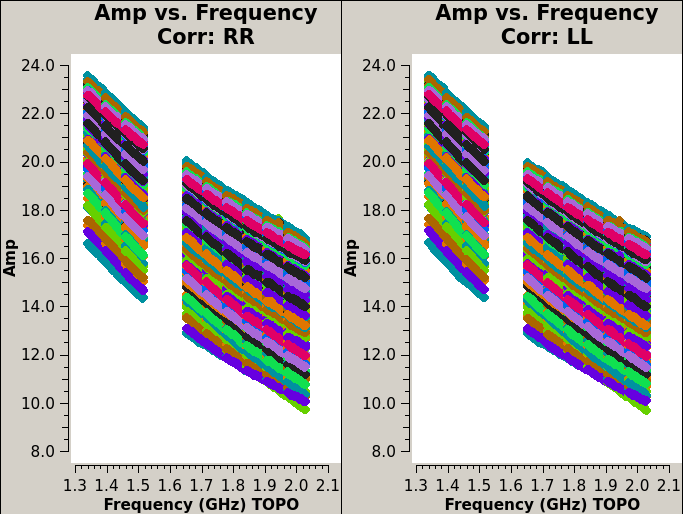

In [28]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

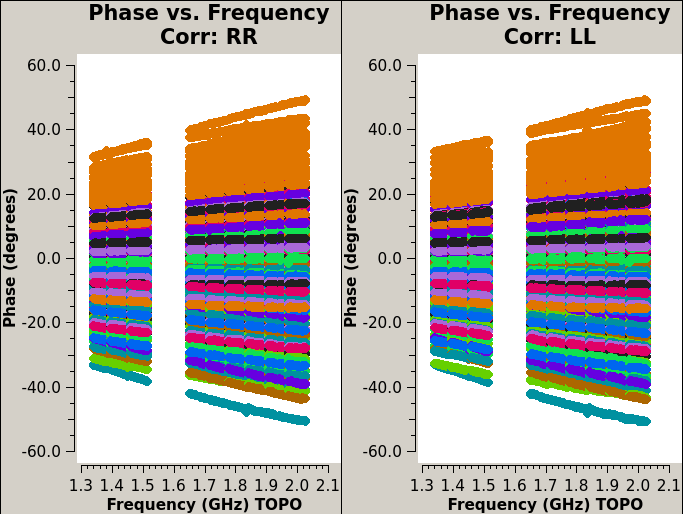

In [29]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

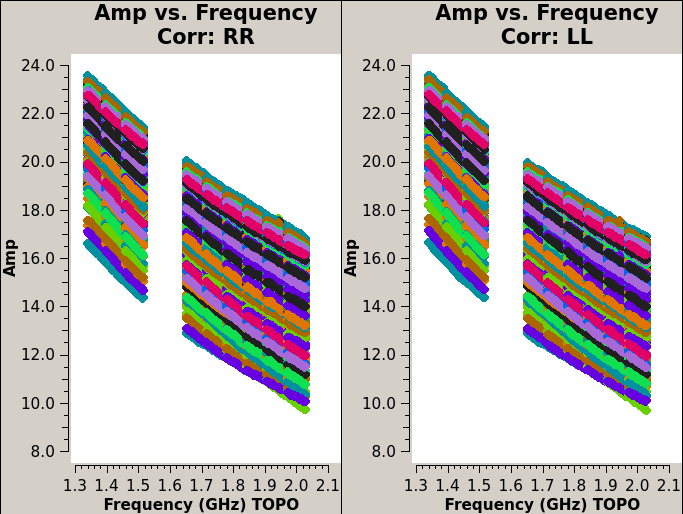

In [30]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

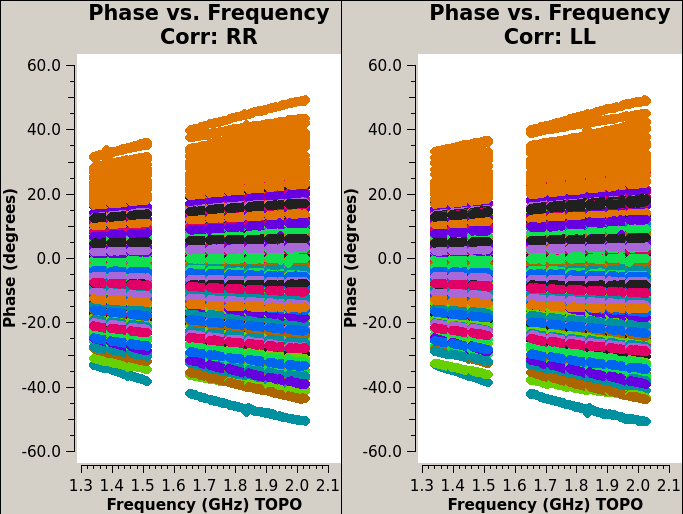

In [31]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [32]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 70.2850, After: 70.3308

antenna ea01
Before: 66.4473, After: 66.4752

antenna ea02
Before: 66.4655, After: 67.0029

antenna ea03
Before: 66.4903, After: 66.5206

antenna ea04
Before: 66.5293, After: 66.5599

antenna ea05
Before: 66.4827, After: 66.5097

antenna ea06
Before: 66.5886, After: 66.6125

antenna ea07
Before: 66.5708, After: 66.6031

antenna ea08
Before: 66.5048, After: 66.5359

antenna ea09
Before: 66.5324, After: 66.5598

antenna ea10
Before: 66.6006, After: 66.6393

antenna ea11
Before: 66.5052, After: 66.5319

antenna ea12
Before: 66.6576, After: 66.7035

antenna ea13
Before: 66.5194, After: 66.5594

antenna ea14
Before: 66.4370, After: 66.4564

antenna ea15
Before: 66.5286, After: 66.5514

antenna ea16
Before: 66.4798, After: 66.5038

antenna ea17
Before: 66.6326, After: 66.6736

antenna ea18
Before: 67.0118, After: 67.0360

antenna ea19
Before: 66.6244, After: 66.6596

ant

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [33]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [34]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

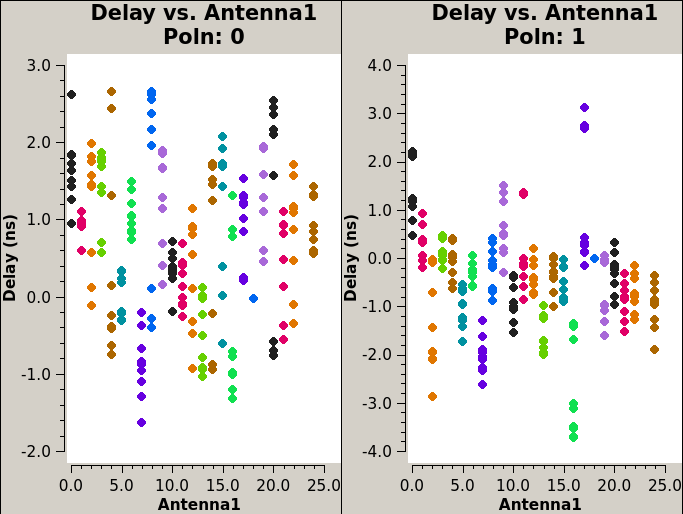

In [35]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [36]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [37]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [38]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

False

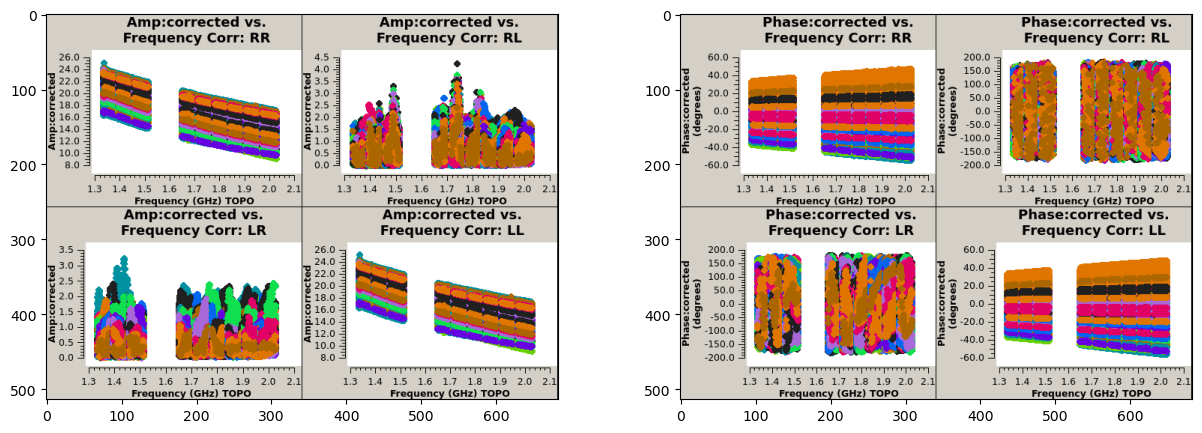

In [39]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_init_cal_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_init_cal_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

"fluxcal_init_cal_amp_vs_freq.png" in os.listdir(root + f"/plots/dataplots/")

### Flag Bandpass Outliers (RFI)

In [40]:
"""
casatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)
casatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)
"""

'\ncasatasks.flagdata(ms, spw="5:0~12", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="10:26~34", reason="Manual Frequency Flagging", flagbackup=False)\ncasatasks.flagdata(ms, spw="14:28~37", reason="Manual Frequency Flagging", flagbackup=False)\n'

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [41]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field J0542+4951
Before: 70.3308, After: 70.3329

antenna ea01
Before: 66.4752, After: 66.4758

antenna ea02
Before: 67.0029, After: 67.0313

antenna ea03
Before: 66.5206, After: 66.5213

antenna ea04
Before: 66.5599, After: 66.5617

antenna ea05
Before: 66.5097, After: 66.5104

antenna ea06
Before: 66.6125, After: 66.6178

antenna ea07
Before: 66.6031, After: 66.6038

antenna ea08
Before: 66.5359, After: 66.5366

antenna ea09
Before: 66.5598, After: 66.5605

antenna ea10
Before: 66.6393, After: 66.6400

antenna ea11
Before: 66.5319, After: 66.5326

antenna ea12
Before: 66.7035, After: 66.7042

antenna ea13
Before: 66.5594, After: 66.5601

antenna ea14
Before: 66.4564, After: 66.4587

antenna ea15
Before: 66.5514, After: 66.5530

antenna ea16
Before: 66.5038, After: 66.5045

antenna ea17
Before: 66.6736, After: 66.6743

antenna ea18
Before: 67.0360, After: 67.0390

antenna ea19
Before: 66.6596, After: 66.6603

ante

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

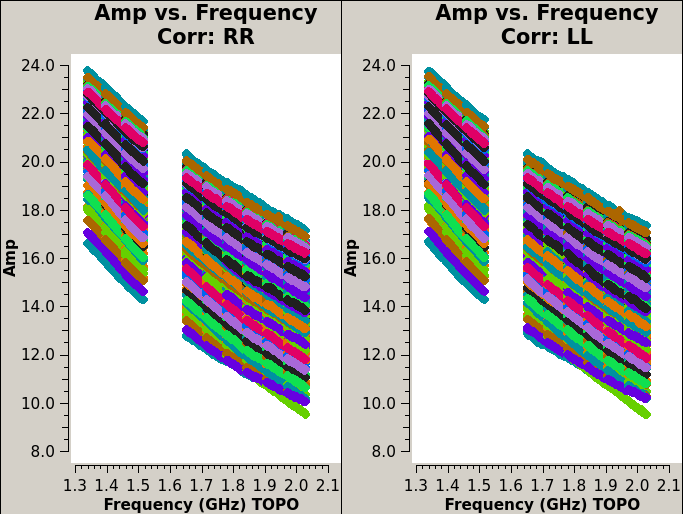

In [42]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

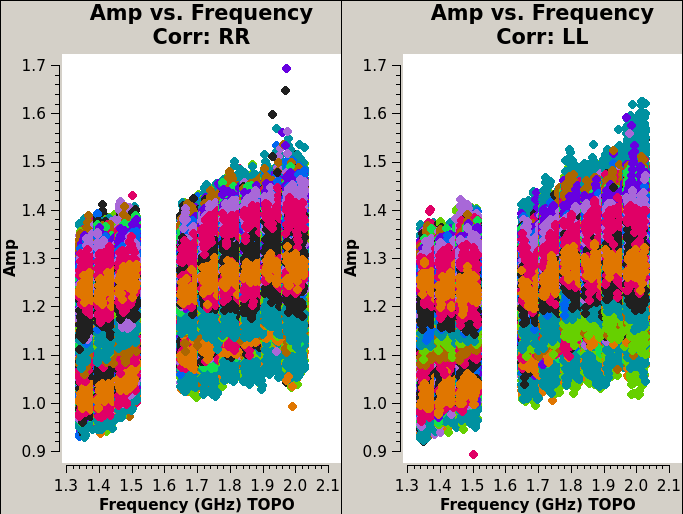

In [43]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

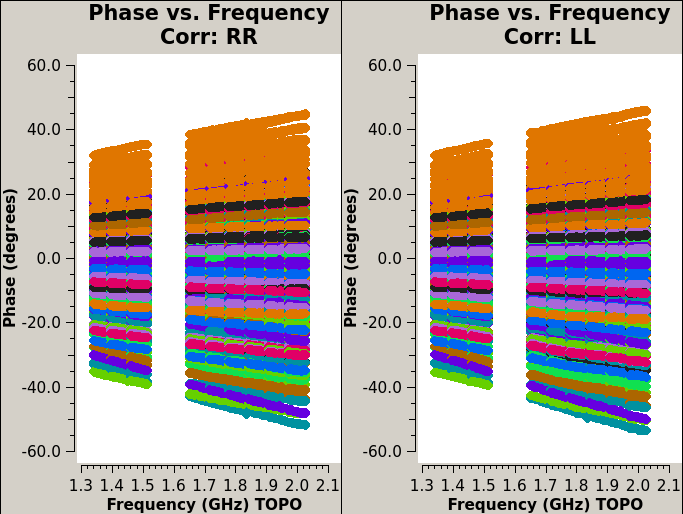

In [44]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

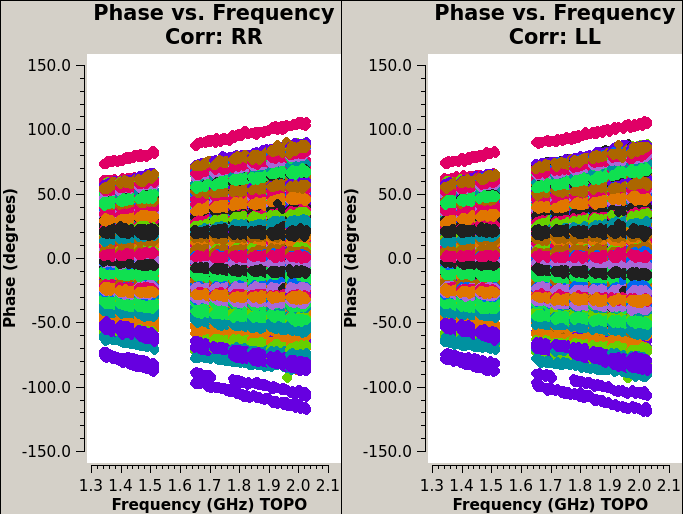

In [45]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

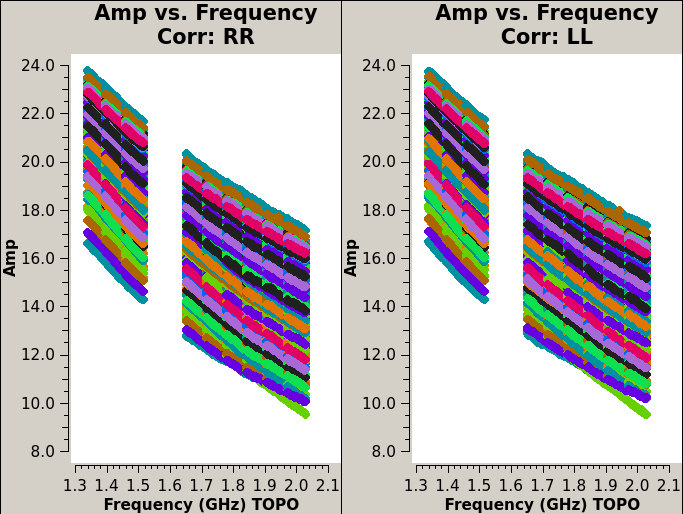

In [46]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

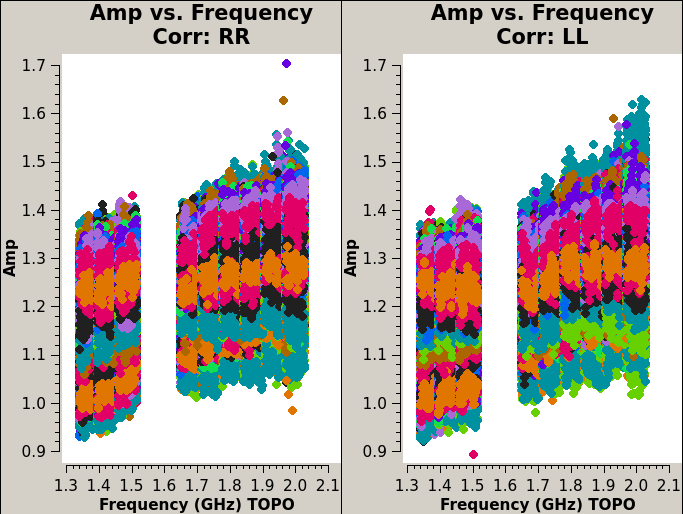

In [47]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

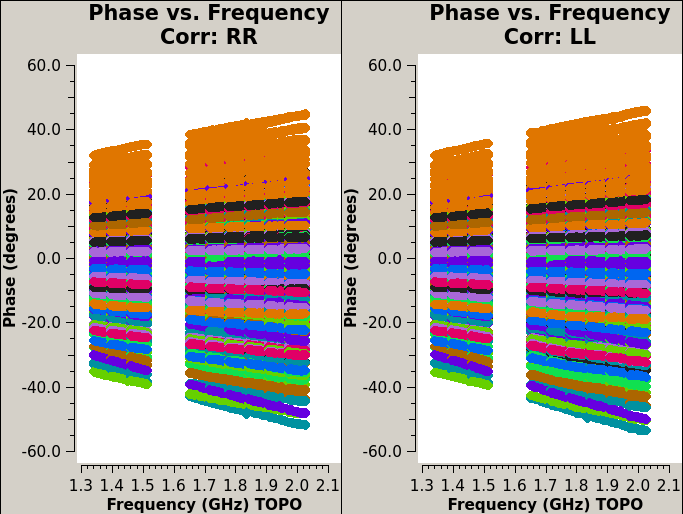

In [48]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

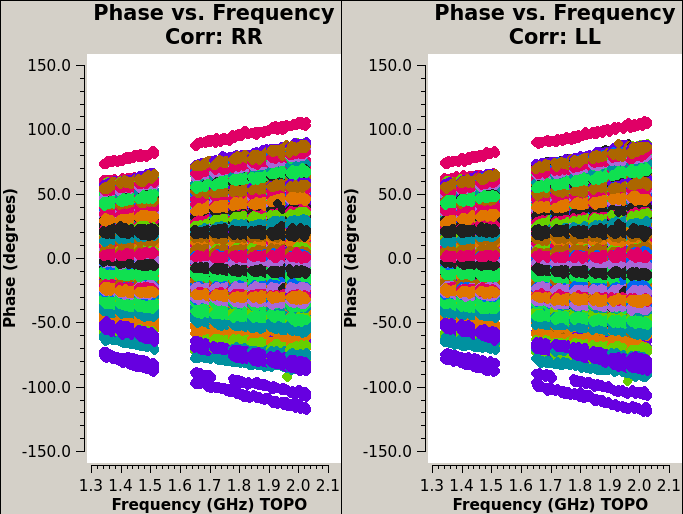

In [49]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [50]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field J0542+4951
Before: 70.3329, After: 70.3528

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 66.8427, After: 66.8649

antenna ea01
Before: 66.4758, After: 66.4811

antenna ea02
Before: 67.0313, After: 67.0446

antenna ea03
Before: 66.5213, After: 66.5424

antenna ea04
Before: 66.5617, After: 66.5926

antenna ea05
Before: 66.5104, After: 66.5264

antenna ea06
Before: 66.6178, After: 66.6500

antenna ea07
Before: 66.6038, After: 66.6375

antenna ea08
Before: 66.5366, After: 66.5538

antenna ea09
Before: 66.5605, After: 66.5719

antenna ea10
Before: 66.6400, After: 66.6714

antenna ea11
Before: 66.5326, After: 66.5469

antenna ea12
Before: 66.7042, After: 66.7550

antenna ea13
Before: 66.5601, After: 66.5929

antenna ea14
Before: 66.4587, After: 66.4639

antenna ea15
Before: 66.5530, After: 66.5682

antenna ea16
Before: 66.5045, After: 66.5180

antenna ea17
Before: 66.6743, After: 66.7177

antenna ea18


In [51]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J1033+4116
Before: 79.2744, After: 79.2836

field J1130+3815
Before: 71.3592, After: 71.3746

scan 3
Before: 86.3754, After: 86.3822

scan 5
Before: 66.8219, After: 66.8354

scan 6
Before: 75.0540, After: 75.0688

scan 8
Before: 67.2026, After: 67.2187

antenna ea01
Before: 73.2376, After: 73.2614

antenna ea02
Before: 72.9723, After: 72.9901

antenna ea03
Before: 72.8917, After: 72.9008

antenna ea04
Before: 72.7514, After: 72.7557

antenna ea05
Before: 72.9360, After: 72.9528

antenna ea06
Before: 72.8516, After: 72.8696

antenna ea07
Before: 73.0296, After: 73.0487

antenna ea08
Before: 73.2426, After: 73.2595

antenna ea09
Before: 72.8583, After: 72.8706

antenna ea10
Before: 73.1834, After: 73.2021

antenna ea11
Before: 72.7570, After: 72.7596

antenna ea12
Before: 73.1456, After: 73.1696

antenna ea13
Before: 72.9453, After: 72.9639

antenna ea14
Before: 72.9473, After: 72.9647

antenna ea15
Before: 

In [52]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:

field J1033+4116
Before: 79.2382, After: 79.3304

field J1130+3815
Before: 71.2671, After: 71.4033

scan 3
Before: 86.3389, After: 86.4030

scan 5
Before: 66.7862, After: 66.9278

scan 6
Before: 74.9544, After: 75.0848

scan 8
Before: 67.1188, After: 67.2616

antenna ea01
Before: 73.1528, After: 73.2748

antenna ea02
Before: 72.8933, After: 73.0235

antenna ea03
Before: 72.8309, After: 72.9271

antenna ea04
Before: 72.7159, After: 72.8243

antenna ea05
Before: 72.8722, After: 72.9892

antenna ea06
Before: 72.7209, After: 72.9435

antenna ea07
Before: 72.9177, After: 73.0221

antenna ea08
Before: 73.1645, After: 73.3156

antenna ea09
Before: 72.8189, After: 72.9330

antenna ea10
Before: 73.1037, After: 73.2341

antenna ea11
Before: 72.7245, After: 72.8306

antenna ea12
Before: 73.0261, After: 73.1775

antenna ea13
Before: 72.8268, After: 73.0090

antenna ea14
Before: 72.8282, After: 73.0367

antenna

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [53]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [54]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

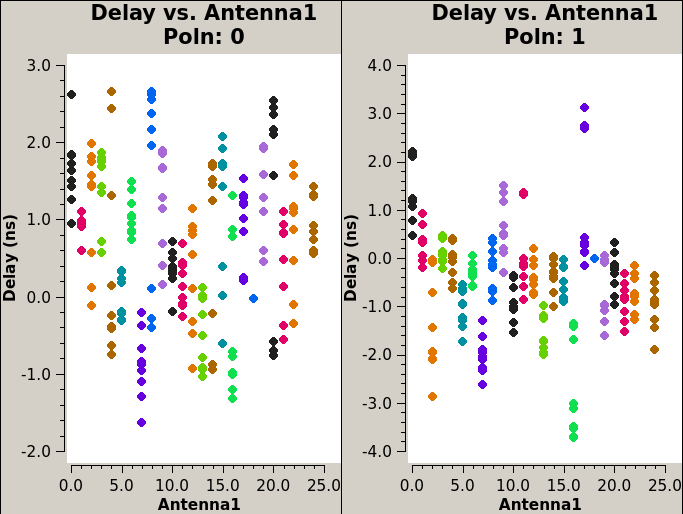

In [55]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [56]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [57]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [58]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [59]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [60]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [61]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [62]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [63]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field J0542+4951
Before: 70.3308, After: 70.3329

antenna ea01
Before: 66.4752, After: 66.4758

antenna ea02
Before: 67.0029, After: 67.0313

antenna ea03
Before: 66.5206, After: 66.5213

antenna ea04
Before: 66.5599, After: 66.5617

antenna ea05
Before: 66.5097, After: 66.5104

antenna ea06
Before: 66.6125, After: 66.6178

antenna ea07
Before: 66.6031, After: 66.6038

antenna ea08
Before: 66.5359, After: 66.5366

antenna ea09
Before: 66.5598, After: 66.5605

antenna ea10
Before: 66.6393, After: 66.6400

antenna ea11
Before: 66.5319, After: 66.5326

antenna ea12
Before: 66.7035, After: 66.7042

antenna ea13
Before: 66.5594, After: 66.5601

antenna ea14
Before: 66.4564, After: 66.4587

antenna ea15
Before: 66.5514, After: 66.5530

antenna ea16
Before: 66.5038, After: 66.5045

antenna ea17
Before: 66.6736, After: 66.6743

antenna ea18
Before: 67.0360, After: 67.0390

antenna ea19
Before: 66.6596, After: 66.6

In [64]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field J0542+4951
Before: 70.3540, After: 70.3540

field J1033+4116
Before: 79.2836, After: 79.2836

field J1130+3815
Before: 71.3746, After: 71.3746

field QSO J1048+4637
Before: 65.3284, After: 65.3284

field QSO J1137+3549
Before: 64.0984, After: 64.0984

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 66.8662, After: 66.8662

scan 3
Before: 86.3822, After: 86.3822

scan 4
Before: 65.3284, After: 65.3284

scan 5
Before: 66.8354, After: 66.8354

scan 6
Before: 75.0688, After: 75.0688

scan 7
Before: 64.0984, After: 64.0984

scan 8
Before: 67.2187, After: 67.2187

antenna ea01
Before: 66.0349, After: 66.0349

antenna ea02
Before: 65.8963, After: 65.8963

antenna ea03
Before: 65.5676, After: 65.5676

antenna ea04
Before: 65.3623, After: 65.3623

antenna ea05
Before: 65.5142, After: 65.5142

antenna ea06
Before: 65.4509, After: 65.4509

antenna ea07
Before: 65.6532, After: 65.6532

antenna ea08
Before: 66.035

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

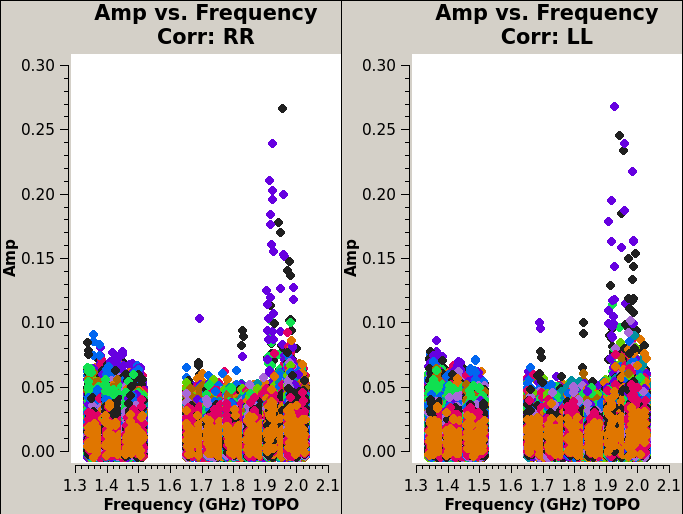

In [65]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

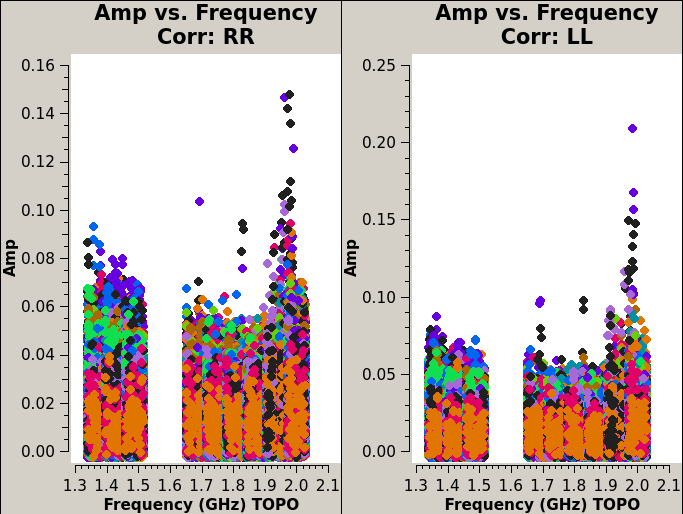

In [66]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [67]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J1048+4637
Before: 65.3284, After: 65.3546

field QSO J1137+3549
Before: 64.0984, After: 64.1663

scan 4
Before: 65.3284, After: 65.3546

scan 7
Before: 64.0984, After: 64.1663

antenna ea01
Before: 61.0556, After: 61.1820

antenna ea02
Before: 60.6204, After: 60.7335

antenna ea03
Before: 60.2354, After: 60.3170

antenna ea04
Before: 59.8538, After: 59.8640

antenna ea05
Before: 60.0929, After: 60.1317

antenna ea06
Before: 59.9425, After: 59.9632

antenna ea07
Before: 60.2751, After: 60.3247

antenna ea08
Before: 61.0191, After: 61.0748

antenna ea09
Before: 60.0716, After: 60.1128

antenna ea10
Before: 60.7403, After: 60.8486

antenna ea11
Before: 59.8701, After: 59.8764

antenna ea12
Before: 60.5905, After: 60.6259

antenna ea13
Before: 60.3144, After: 60.4090

antenna ea14
Before: 60.1852, After: 60.2657

antenna ea15
Before: 59.8994, After: 59.9160

antenna ea16
Before: 59.9984, After: 60.0524

antenna ea17
B

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [68]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

J0542+4951


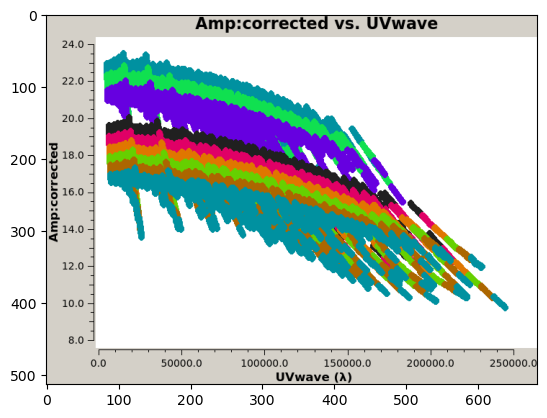

J1033+4116


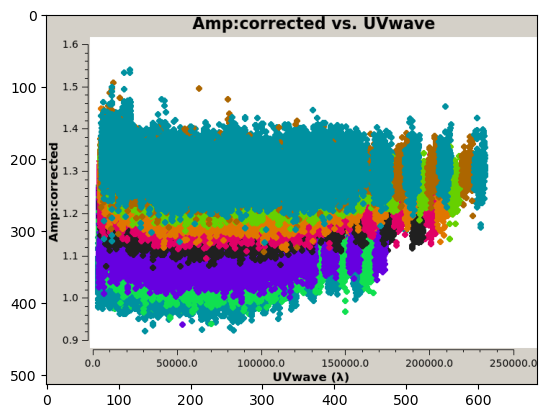

J1130+3815


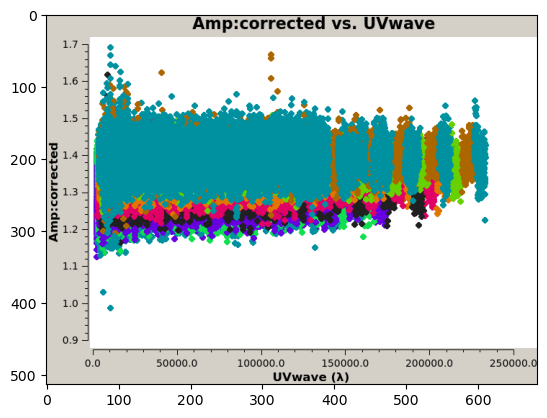

QSO J1048+4637


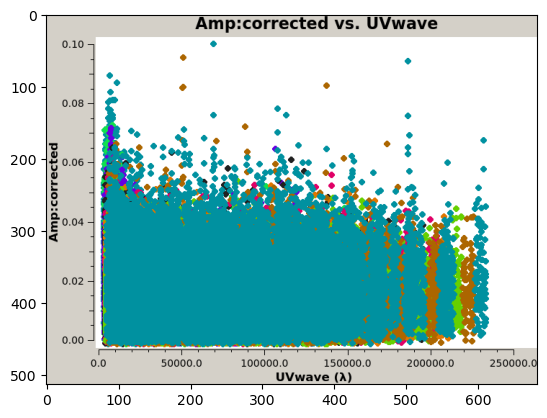

QSO J1137+3549


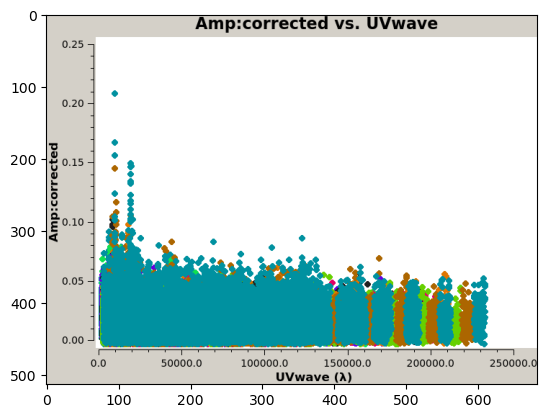

In [69]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


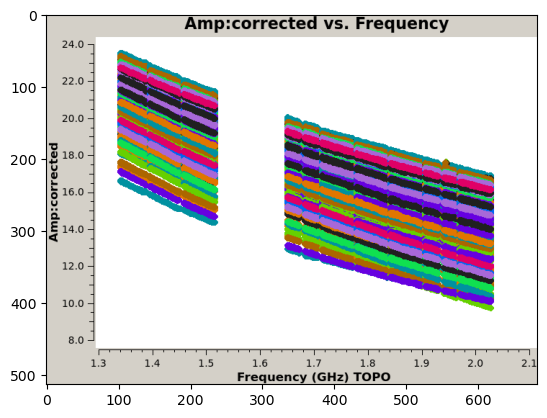

J1033+4116


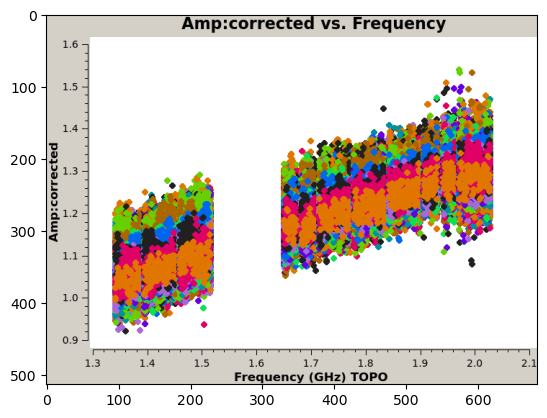

J1130+3815


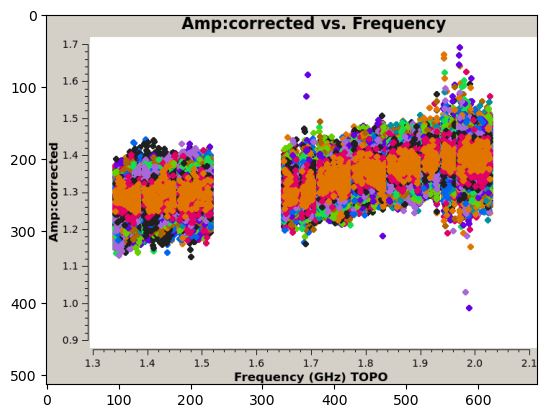

QSO J1048+4637


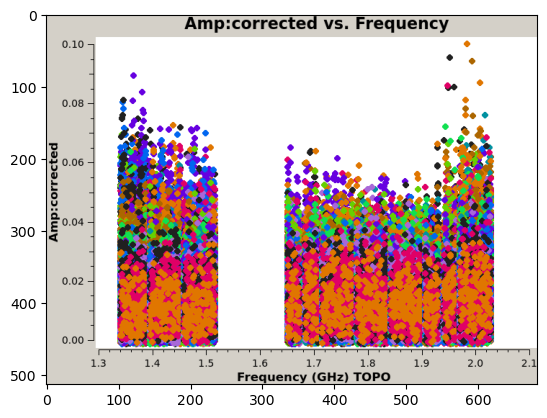

QSO J1137+3549


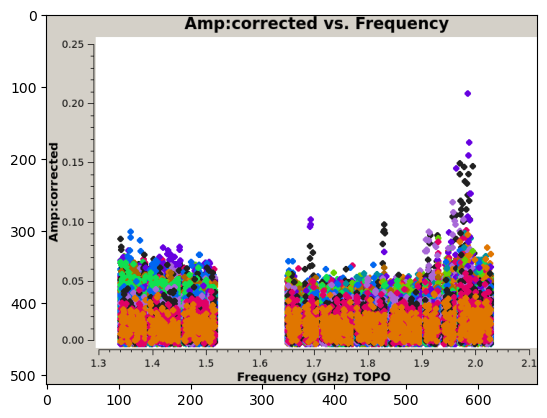

In [70]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

J0542+4951


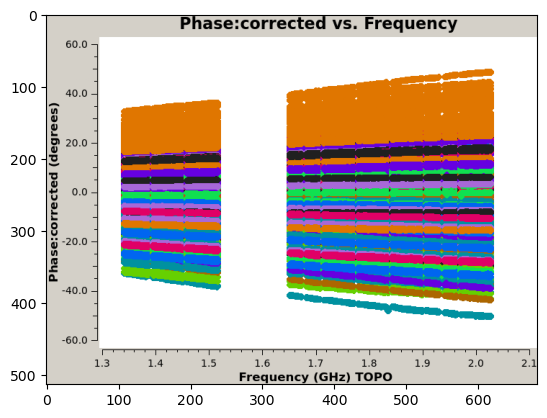

J1033+4116


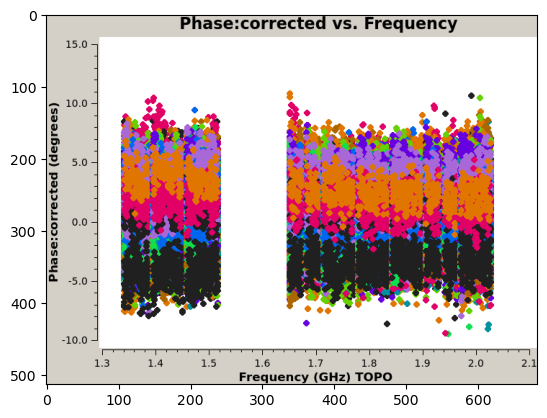

J1130+3815


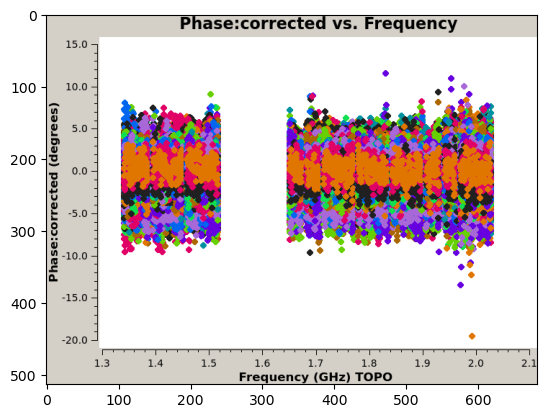

QSO J1048+4637


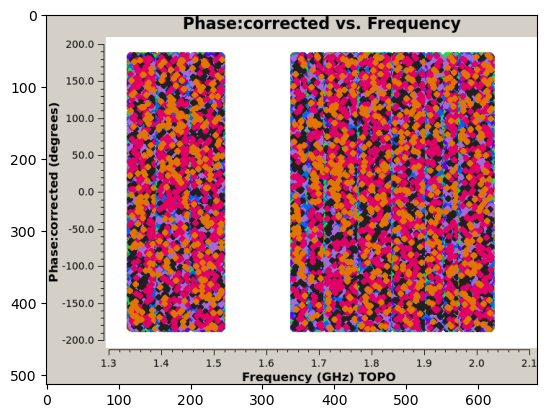

QSO J1137+3549


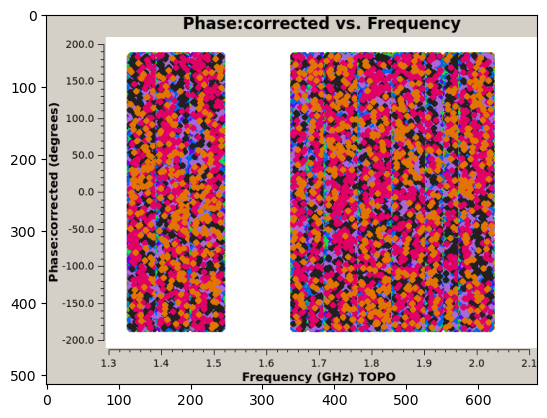

In [71]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [72]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

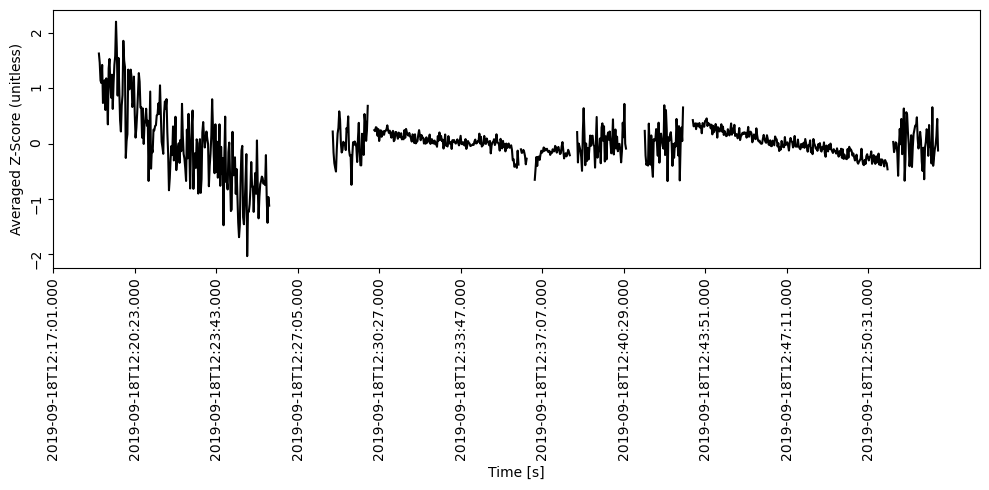

In [73]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

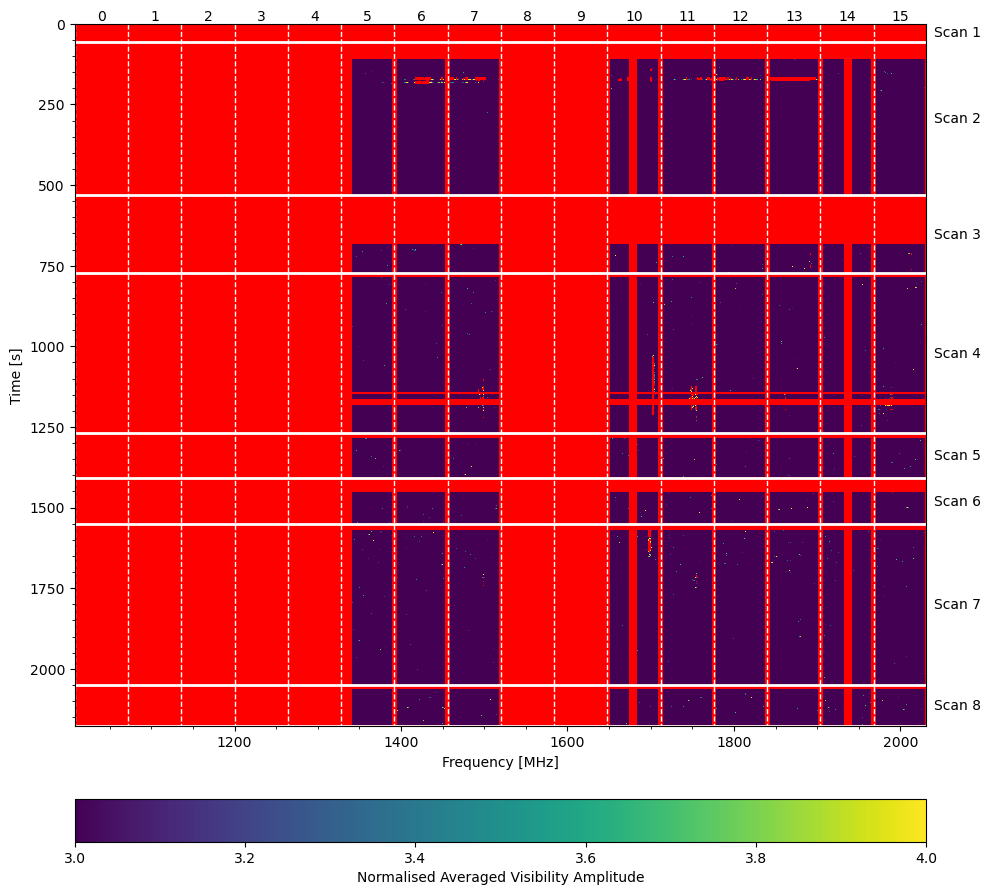

In [74]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")